In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [33]:
data = pd.read_csv('data_raw.csv')
data_original = data.copy()

In [34]:
# Print number of rows and columns
data_original.shape

(8707, 11)

In [35]:
# first of all, let's remove duplicates (people with the same pay from the same department)
data = data.drop_duplicates()
# we are then left with 8526 rows
data.shape

(8526, 11)

In [ ]:
# let's have a look at the first 5 entries
data.head()

In [36]:
# it looks like the 'Overall Pay' already takes into account the sum of the 12M, 9M, 3M values minus the fees. Let's check the sum:
data[['12 M Gross Pay',	'9 M Gross Pay', '3 M Gross Pay']].sum()

Series([], dtype: float64)

In [37]:
# That didn't work because the Gross Pay columns are not formatted as floats
data.dtypes

University         object
Department         object
Overall Pay        object
LW Ratio          float64
Academic Year      object
Program Year       object
12 M Gross Pay     object
9 M Gross Pay      object
3 M Gross Pay      object
Fees               object
Comments           object
dtype: object

In [38]:
# In order to format them as floats, let's first remove the dollar sign
data['Overall Pay'] = data['Overall Pay'].str.replace('$', '')
data['12 M Gross Pay'] = data['12 M Gross Pay'].str.replace('$', '')
data['9 M Gross Pay'] = data['9 M Gross Pay'].str.replace('$', '')
data['3 M Gross Pay'] = data['3 M Gross Pay'].str.replace('$', '')
data['Fees'] = data['Fees'].str.replace('$', '')

# and also remove the commas
data['Overall Pay'] = data['Overall Pay'].str.replace(',', '')
data['12 M Gross Pay'] = data['12 M Gross Pay'].str.replace(',', '')
data['9 M Gross Pay'] = data['9 M Gross Pay'].str.replace(',', '')
data['3 M Gross Pay'] = data['3 M Gross Pay'].str.replace(',', '')
data['Fees'] = data['Fees'].str.replace(',', '')

# while we are doing these string replacements, let's also clean up the university names
data['University'] = data['University'].str.replace('-',',').str.replace(';','').str.replace('&amp','&').str.replace('&#39','\'')

In [ ]:
data.head()

In [39]:
# And finally convert the relevant columns to float
data[['Overall Pay', '12 M Gross Pay',	'9 M Gross Pay', '3 M Gross Pay', 'Fees']] = data[['Overall Pay', '12 M Gross Pay', '9 M Gross Pay', '3 M Gross Pay', 'Fees']].astype(float)
data.dtypes

University         object
Department         object
Overall Pay       float64
LW Ratio          float64
Academic Year      object
Program Year       object
12 M Gross Pay    float64
9 M Gross Pay     float64
3 M Gross Pay     float64
Fees              float64
Comments           object
dtype: object

In [40]:
# Now we can confirm that the 'Overall Pay' is equal to the sum of the 12M, 9M, 3M values minus the fees
data['Overall Pay'].sum() == data[['12 M Gross Pay', '9 M Gross Pay', '3 M Gross Pay']].sum().sum() - data['Fees'].sum()

True

In [41]:
# so we can remove the 12M, 9M, 3M and fees columns and simplify the DataFrame
data = data.drop(['12 M Gross Pay', '9 M Gross Pay', '3 M Gross Pay', 'Fees'], axis=1)
data.head()

,University,Department,Overall Pay,LW Ratio,Academic Year,Program Year,Comments
0,"University of Tennessee , Knoxville",Economics,1850.0,0.09,2020-2021,1st,NaN
1,University of Arizona (U of A),Economics,21000.0,1.01,2020-2021,1st,$10500 per semester. RA/TA required. Need to p...
2,University of Arizona (U of A),Economics,19800.0,0.96,2020-2021,1st,NaN
3,University of Florida,ECE,22600.0,NaN,2020-2021,1st,NaN
4,University of Virginia (UVA),ECE,26000.0,1.14,2020-2021,1st,NaN


In [42]:
# use pandas 'describe' function to get basic statistics of the numerical columns
data.describe()

,Overall Pay,LW Ratio
count,8505.000000,7651.000000
mean,25153.337331,1.075993
std,21805.844892,0.834647
min,-900000.000000,-34.010000
25%,19007.000000,0.850000
50%,25000.000000,1.100000
75%,30445.000000,1.300000
max,994000.000000,40.970000


0 percentile: -900000.00
100 percentile: 994000.00


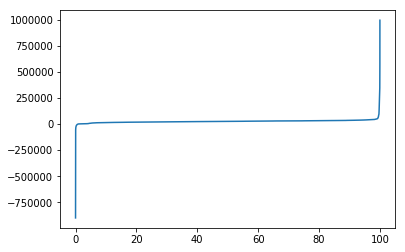

In [43]:
# the max and min values are very far from the median (50% percentile) and from the 25-75% percentiles, which suggests there are ouliers. To confirm that, the plot of the inverse CDF (cumulative distribution) has very sharp jumps at the start and end:
def plot_inverse_CDF(data, min_perc=0, max_perc=100, step=0.01, vlines=[]):
    percentiles = np.arange(min_perc, max_perc+step, step)
    inv_CDF = [np.nanpercentile(data, p) for p in percentiles]
    print('{0} percentile: {1:.2f}'.format(min_perc, inv_CDF[0]))
    print('{0} percentile: {1:.2f}'.format(max_perc, inv_CDF[-1]))
    plt.plot(percentiles, inv_CDF)
    for x in vlines:
        plt.axvline(x=x, linestyle='--', color='r')
    plt.show()
plot_inverse_CDF(data=data['Overall Pay'].values)

0 percentile: -900000.00
100 percentile: 994000.00


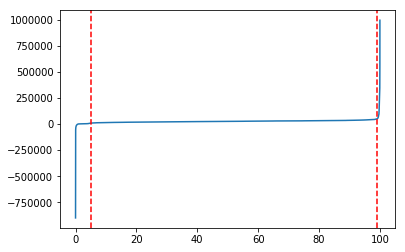

5 percentile: 7500.00
99 percentile: 48498.96


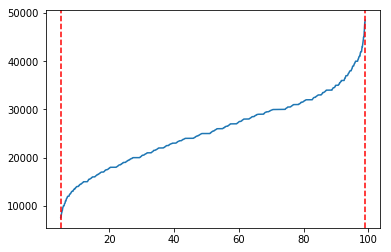

min_pay_threshold = 7500.0
max_pay_threshold = 48498.95999999998


In [44]:
# Let's then excude the bottom 5% and top 1% of the values, in order to ignore the extreme cases (in particular the negative values, where the fees are higher than the pay). The remaining pay values are between $7500.00 and $48498.96
min_perc_threshold = 5
max_perc_threshold = 99
plot_inverse_CDF(data=data['Overall Pay'].values, vlines=[min_perc_threshold, max_perc_threshold])
plot_inverse_CDF(data=data['Overall Pay'].values, min_perc=min_perc_threshold, max_perc=max_perc_threshold, vlines=[min_perc_threshold, max_perc_threshold])
min_pay_threshold, max_pay_threshold = np.nanpercentile(data['Overall Pay'].values, [min_perc_threshold, max_perc_threshold])
print('min_pay_threshold = {0}'.format(min_pay_threshold))
print('max_pay_threshold = {0}'.format(max_pay_threshold))
data = data[(data['Overall Pay']>=min_pay_threshold) & (data['Overall Pay']<=max_pay_threshold)]

In [45]:
# after cleaning, we are left with 7996 rows
data.shape

(7996, 7)

In [46]:
# the median didn't change (still $25500), but now the STD is more reasonable ($7355 instead of $21805)
data.describe()

,Overall Pay,LW Ratio
count,7996.000000,7262.000000
mean,25523.989370,1.097447
std,7355.036001,0.285997
min,7500.000000,0.250000
25%,20000.000000,0.880000
50%,25500.000000,1.115000
75%,30500.000000,1.300000
max,48474.000000,2.510000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000201CE91ECF8>,
      dtype=object)

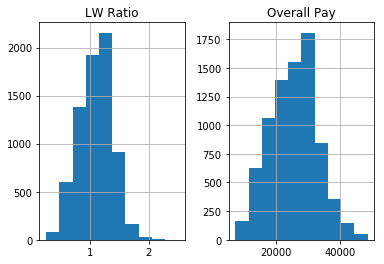

In [47]:
# The histograms of the LW Ratio and Overall Pay
data.hist()

In [48]:
# 36% of the remaining PhD salaries after cleaning are still below the living wage
(data['LW Ratio']<=1).sum() / len(data['LW Ratio'].dropna())

0.3646378408152024

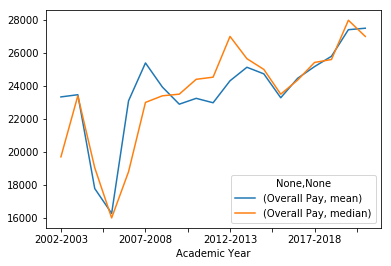

In [49]:
# the mean and median pay fluctuate over the years, with a small upward trend
data[['Overall Pay', 'Academic Year']].groupby('Academic Year').agg(['mean', 'median']).plot()

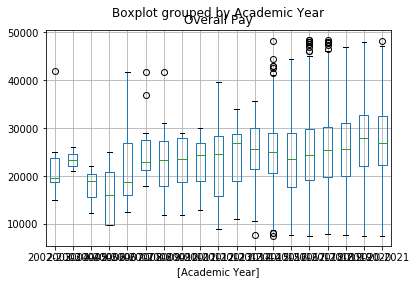

In [50]:
# however, we should take into account the high variance around the mean
data[['Overall Pay', 'Academic Year']].boxplot(by='Academic Year')

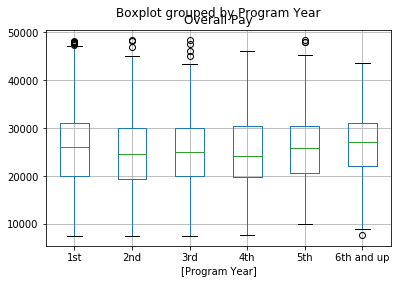

In [51]:
# on the other hand, there is no significant variation of pay over the course of the PhD program
data[['Overall Pay', 'Program Year']].boxplot(by='Program Year')

In [ ]:
# get locations from Mapbox and add them to the DataFrame (https://github.com/mapbox/mapbox-sdk-py/blob/master/docs/geocoding.md#geocoding)
# If you don't want to set up Mapbox, you can skip to the next cell to load the geo-tagged data
from mapbox import Geocoder
with open('mapbox_tkn.txt', 'r') as f:
    mapbox_key = f.read().strip()
geocoder = Geocoder(access_token=mapbox_key)
data.assign(lon=np.NaN)
data.assign(lat=np.NaN)
uni_names = data['University'].dropna().unique()
for i, uni in enumerate(uni_names[174:]):
    print(uni)
    response = geocoder.forward(uni, limit=1)
    if response.geojson()['features']:
        lon, lat = response.geojson()['features'][0]['center']
        print(lon, lat)
        mask = data['University'] == uni
        data.loc[mask, 'lon'] = lon
        data.loc[mask, 'lat'] = lat
        print('\n')
# save geo-tagged data
data.to_csv('data_cleaned_geoloc.csv')
data.head()

In [52]:
# load geo-tagged data
data = pd.read_csv('data_cleaned_geoloc.csv')

In [ ]:
# Aggregate nearby universities and compute average pay.
# This takes a long time to run!!! You can skip to the next cell to load the final aggregated and geo-tagged data.
# adapted from: https://www.jphwang.com/interactive-maps-with-python-pandas-and-plotly/
data = data.assign(merged=False)
data = data.assign(counts=1)
data = data.assign(pay_sum=data['Overall Pay'])
dist_thresh = 0.0001
for i in range(len(data)):
    src_ind = data.iloc[i].name
    if not data.loc[src_ind]['merged']:
        print(src_ind)
        for j in range(i+1, len(data)):
            tgt_ind = data.iloc[j].name
            if not data.loc[tgt_ind]['merged']:
                lat_dist = data.loc[src_ind]['lat'] - data.loc[tgt_ind]['lat']
                lon_dist = data.loc[src_ind]['lon'] - data.loc[tgt_ind]['lon']
                tot_dist = (lat_dist ** 2 + lon_dist ** 2) ** 0.5
                if tot_dist < dist_thresh:
                    print(f'Found duplicate item "{data.loc[tgt_ind]["University"]}", index {tgt_ind}')
                    data.loc[src_ind, 'counts'] += 1
                    data.loc[src_ind, 'pay_sum'] += data.loc[tgt_ind, 'Overall Pay']
                    if data.loc[tgt_ind, 'University'] not in data.loc[src_ind, 'University']:
                        data.loc[src_ind, 'University'] = data.loc[src_ind, 'University'] + ' | ' + data.loc[tgt_ind, 'University']
                    data.loc[tgt_ind, 'merged'] = True

# Update counts
data = data[data.merged == False]
data = data.assign(pay_average=data['pay_sum']/data['counts'])
# save final aggregated and geo-tagged data
data.to_csv('data_cleaned_geoloc_aggregated.csv')

In [53]:
# load final aggregated and geo-tagged data
data = pd.read_csv('data_cleaned_geoloc_aggregated.csv')
with open('mapbox_tkn.txt', 'r') as f:
    mapbox_key = f.read().strip()

In [57]:
# display interactive and zoomable world map, with colour and size of universities proportional to the average pay (tooltip shows university name and average pay)
import plotly.express as px
fig = px.scatter_mapbox(
    data, lat="lat" , lon="lon", color="pay_average", size="pay_average",
    hover_name='University', hover_data=['pay_average'], zoom=0.2, size_max=15)
fig.update_layout(mapbox_style="light", mapbox_accesstoken=mapbox_key)
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show(config={'displayModeBar': False, 'editable': False})

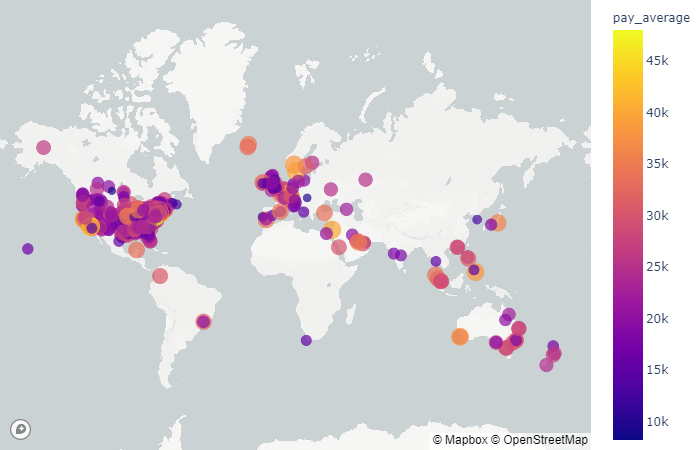

In [58]:
# display the non-interactive version of the map
from IPython.display import Image
Image(filename='world_map.png') 